In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/Artificial NN & Deep Learning/Assignment 1


In [2]:
!pip install  keras-cv tensorflow
!pip install  keras-cv tensorflow
!pip install  keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras_cv.layers import RandomSaturation
from keras_cv.layers import RandomSharpness
from keras_cv.layers import RandomShear
from keras_cv.layers import Solarization
from keras_cv.layers import Augmenter

In [4]:
file_path = 'Clean_Dataset.npz'

with np.load(file_path) as data:
    training_images = data['images'] #/ 255.0
    training_labels = data['labels']

# Check
print(f"Shape of images: {training_images.shape}")
print(f"type of images: {type(training_images)}")
print(f"shape of labels: {training_labels.shape}")
print(f"type of labels: {type(training_labels)}")
# Dataframe for labels
labels = training_labels.flatten()
df_labels = pd.DataFrame(labels, columns=['label'])
print(df_labels.head())

Shape of images: (11943, 96, 96, 3)
type of images: <class 'numpy.ndarray'>
shape of labels: (11943, 1)
type of labels: <class 'numpy.ndarray'>
   label
0      7
1      3
2      6
3      6
4      7


In [5]:
# train test val split

from sklearn.model_selection import train_test_split

# Define split sizes
test_size = 0.2        # 20% for test
validation_size = 0.2  # 20% of the remaining 80% = 16% for validation

# Split into (training+validation) and test sets
training_labels = training_labels.flatten()
X_train_val, X_test, y_train_val, y_test = train_test_split(
    training_images,
    training_labels,
    test_size=test_size,
    random_state=42,
    stratify=training_labels
)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=validation_size,
    random_state=42,
    stratify=y_train_val
)
print("Training Images - Min pixel value:", np.min(X_train))
print("Training Images - Max pixel value:", np.max(X_train))
print("Validation Images - Min pixel value:", np.min(X_val))
print("Validation Images - Max pixel value:", np.max(X_val))
print("Test Images - Min pixel value:", np.min(X_test))
print("Test Images - Max pixel value:", np.max(X_test))
print("-----------------------------------------------------")
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training Images - Min pixel value: 0
Training Images - Max pixel value: 255
Validation Images - Min pixel value: 0
Validation Images - Max pixel value: 255
Test Images - Min pixel value: 0
Test Images - Max pixel value: 255
-----------------------------------------------------
Training set shape: (7643, 96, 96, 3), (7643,)
Validation set shape: (1911, 96, 96, 3), (1911,)
Test set shape: (2389, 96, 96, 3), (2389,)


In [6]:
#class_counts = np.bincount(training_labels)
class_counts = pd.Series(y_train).value_counts()  # Use only y_train, not the full label set

# `class_counts` now contains the size of each class:
# - `class_counts[j]` gives the count of items with class label `j`.

max_count = class_counts.max()
print(f"Maximum class count: {max_count}")

# Initialize lists to hold oversampled data
X_train_oversampled = []
y_train_oversampled = []

# Iterate through each class to perform oversampling
for class_label in class_counts.index:
    # Current class samples
    X_class = X_train[y_train == class_label]
    y_class = y_train[y_train == class_label]

    # Number of samples to add
    samples_needed = max_count - len(X_class)

    if samples_needed > 0:
        # Calculate how many times to duplicate the class samples
        duplicates = samples_needed // len(X_class)
        remainder = samples_needed % len(X_class)

        # Duplicate the entire class as many times as needed
        for _ in range(duplicates):
            X_train_oversampled.append(X_class)
            y_train_oversampled.append(y_class)

        # Add the remaining samples by randomly selecting from the class
        if remainder > 0:
            indices = np.random.choice(len(X_class), size=remainder, replace=True)
            X_train_oversampled.append(X_class[indices])
            y_train_oversampled.append(y_class[indices])

# Concatenate the oversampled data
if X_train_oversampled:
    X_train_oversampled = np.vstack(X_train_oversampled)
    y_train_oversampled = np.hstack(y_train_oversampled)

    # Append the oversampled data to the original training set
    X_train_balanced = np.vstack((X_train, X_train_oversampled))
    y_train_balanced = np.hstack((y_train, y_train_oversampled))
else:
    # If no oversampling is needed
    X_train_balanced = X_train
    y_train_balanced = y_train

print(f"Training set shape after oversampling: {X_train_balanced.shape}, {y_train_balanced.shape}")

Maximum class count: 1491
Training set shape after oversampling: (11928, 96, 96, 3), (11928,)


X_train_balanced, y_train_balanced are created. I also have X_val, y_val, X_test, y_test. Now let's augment the training set, and process all the data to the right format then train.

In [112]:
import tensorflow as tf
import keras_cv
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# Define the augmentation pipeline
augmentation_pipeline = keras_cv.layers.Augmenter([
    keras_cv.layers.RandomSaturation(factor=(0, 1.0)),
    keras_cv.layers.RandomSharpness(factor=(0, 1.0), value_range=[0, 255])
    ])
""",
    keras_cv.layers.RandomSaturation(factor=(0, 1.0))
    keras_cv.layers.RandomSharpness(factor=(0, 1.0), value_range=[0, 255]),
    keras_cv.layers.RandomShear(
        x_factor=0.3,
        y_factor=0.3,
        interpolation="bilinear",
        fill_mode="reflect",
        fill_value=0.0),
    keras_cv.layers.Solarization(value_range=[0, 255])
])"""

# Augmentation function
def augment_image(image, label, augment=True):
    # Resize the image to 299x299 to match the model input
    image = tf.image.resize(image, [299, 299])
    # If augmentation is enabled, apply the augmentations
    if augment:
        image = augmentation_pipeline(image)
    # Normalize image for InceptionResNetV2
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - tf.constant([0.485, 0.456, 0.406])) / tf.constant([0.229, 0.224, 0.225])
    # Ensure label is cast to int32
    label = tf.cast(label, tf.int32)
    return image, label

# Wrapper function for TensorFlow dataset
def tf_augment_image(image, label, augment=True):
    # Apply augmentation if needed
    if augment:
        augmented_image, augmented_label = tf.py_function(
            func=augment_image,
            inp=[image, label],
            Tout=[tf.float32, tf.int32]
        )
        augmented_image.set_shape((299, 299, 3))  # Ensure correct shape
        augmented_label.set_shape(())
        return augmented_image, augmented_label
    else:
        # No augmentation for validation and test data
        return preprocess(image, label)

# Preprocessing function (for resizing and standardizing)
def preprocess(image, label):
    image = tf.image.resize(image, [299, 299])  # Resize to 299x299
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # Normalize using InceptionResNetV2's preprocess_input
    label = tf.cast(label, tf.int32)
    return image, label

# Create the datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply augmentation and resizing for the training dataset
train_dataset = train_dataset.map(
    lambda image, label: tf_augment_image(image, label, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Apply no augmentation and resizing for validation and test datasets
val_dataset = val_dataset.map(
    lambda image, label: tf_augment_image(image, label, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(
    lambda image, label: tf_augment_image(image, label, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes of a batch from the training, validation, and test datasets
for dataset_name, dataset in [("train", train_dataset), ("val", val_dataset), ("test", test_dataset)]:
    for image_batch, label_batch in dataset.take(1):  # Take the first batch
        print(f"{dataset_name} dataset - Image batch shape: {image_batch.shape}, Label batch shape: {label_batch.shape}")


# train dataset - Image batch shape: (32, 299, 299, 3), Label batch shape: (32,)
# val dataset - Image batch shape: (32, 299, 299, 3), Label batch shape: (32,)
# test dataset - Image batch shape: (32, 299, 299, 3), Label batch shape: (32,)

train dataset - Image batch shape: (32, 299, 299, 3), Label batch shape: (32,)
val dataset - Image batch shape: (32, 299, 299, 3), Label batch shape: (32,)
test dataset - Image batch shape: (32, 299, 299, 3), Label batch shape: (32,)


Let's see how the data look like (only training set was augmented) :

Augmented Train Images:


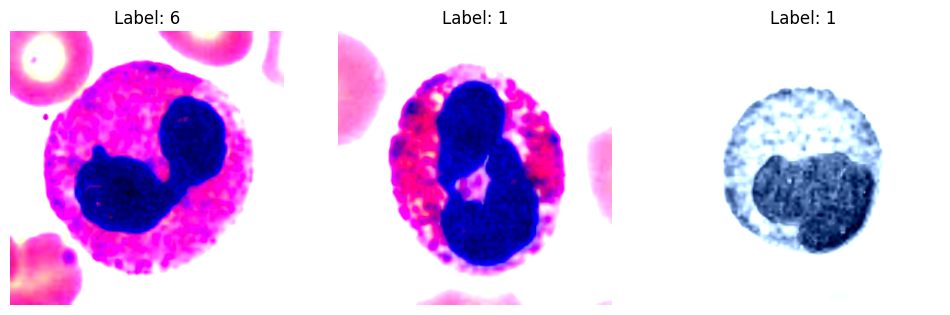

Validation Images:


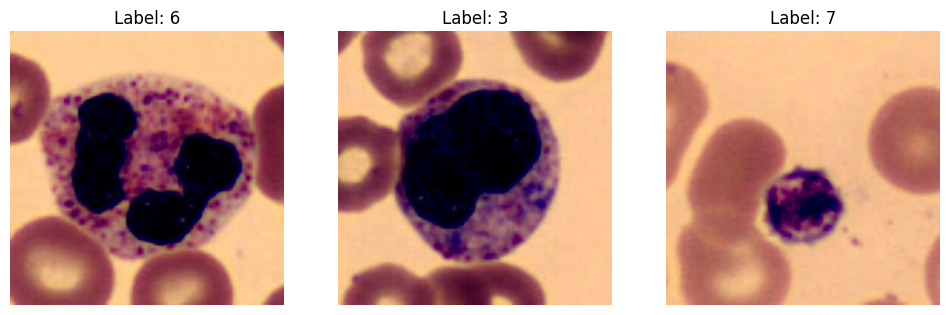

Test Images:


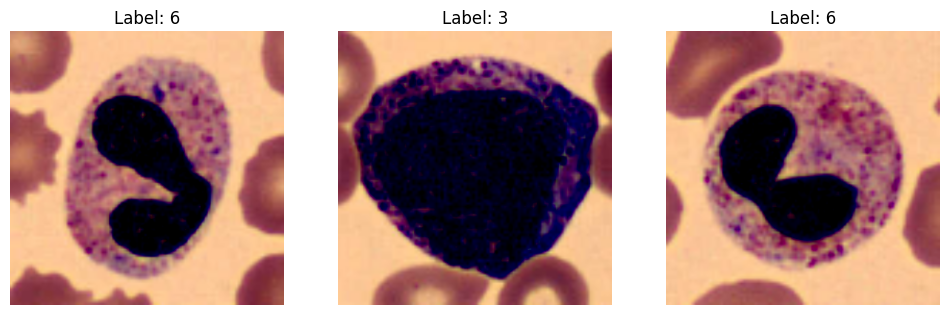

In [113]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to plot 3x3 grid of images
def plot_images(dataset, num_images=3, augment=True):
    images = []
    labels = []

    # Get the first 'num_images' samples from the dataset
    for image_batch, label_batch in dataset.take(1):
        images = image_batch.numpy()[:num_images]
        labels = label_batch.numpy()[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.show()

# Display 3 augmented images from the training dataset
print("Augmented Train Images:")
plot_images(train_dataset, num_images=3, augment=True)

# Display 3 validation images (no augmentation)
print("Validation Images:")
plot_images(val_dataset, num_images=3, augment=False)

# Display 3 test images (no augmentation)
print("Test Images:")
plot_images(test_dataset, num_images=3, augment=False)

Now let's feed the model with those data.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import numpy as np

# Model setup
input_shape = (299, 299, 3)
inputs = layers.Input(shape=input_shape)

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Freeze base model

x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(8, activation='softmax', dtype='float32')(x)  # 8 classes

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_inception_resnet_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callback_list = [early_stop, model_checkpoint, reduce_lr]

# Train the model
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callback_list,
)

# Plotting results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

Epoch 1/10
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5441 - loss: 1.3372

In [ ]:
model.summary()

In [ ]:
# Plotting results
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Generate Predictions
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Step 2: Calculate the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 3: Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(8))  # Assuming 8 classes
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk

def plot_image_with_prediction(image, model, class_names):
    # Preprocess the image for model prediction
    preprocessed_image = tf.image.resize(image, (299, 299))  # resize for InceptionResNetV2
    preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)  # add batch dimension
    preprocessed_image = tf.keras.applications.inception_resnet_v2.preprocess_input(preprocessed_image)

    # Get prediction probabilities
    prediction = model.predict(preprocessed_image)[0]

    # Set up the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the image
    axes[0].imshow(image / 255.0)  # Assuming image is in uint8 format
    axes[0].axis('off')
    axes[0].set_title("Input Image")

    # Plot the prediction probabilities as a bar chart
    bar_positions = np.arange(len(class_names))
    axes[1].barh(bar_positions, prediction, align='center')
    axes[1].set_yticks(bar_positions)
    axes[1].set_yticklabels(class_names)
    axes[1].invert_yaxis()  # Highest probability at the top
    axes[1].set_xlabel("Prediction Probability")
    axes[1].set_title("Prediction Probabilities")

    plt.tight_layout()
    plt.show()

#
image = X_test[1]
# model = tfk.models.load_model('AUGMENTED_NOE.keras')
class_names = ["0", "1", "2", "3", "4", "5", "6", "7"]
plot_image_with_prediction(image, model, class_names)

## To save :

In [ ]:
model.save('weights.keras')
del model

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        # X /= 255.0

        # Preprocessing function (for resizing and standardizing)
        def preprocess(image, label):
            image = tf.image.resize(image, [299, 299])  # Resize to 299x299
            image = tf.cast(image, tf.float32)
            image = preprocess_input(image)  # Normalize using InceptionResNetV2's preprocess_input
            label = tf.cast(label, tf.int32)
            return image, label

        X = X.map(
            lambda image, label: tf_augment_image(image, label, augment=False),
            num_parallel_calls=tf.data.AUTOTUNE)
        X = X.batch(32).prefetch(tf.data.AUTOTUNE)

        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py
